# # 신용대출 심사 feature 값에 따른 예측값 변화량 분석

* 고객사는 ## 은행입니다. 신용평가 업무를 인공지능으로 전환하고자 여러분에게 모델링을 의뢰하였습니다.
* 대출업무는
    * 은행 창구에서 신청을 받고
    * 본사의 심사부서에서는 신용평가를 통해 대출 신청에 대한 승인 여부를 결정해 왔습니다.

* 현장의 요구
    * 경쟁사의 공격적인 대출상품 판매로, 본사에서는 자사 은행의 대출 실적이 줄어들고 있는 것에 부담을 느끼고 있습니다.
    * 그런데, 자사 은행에서는 신용평가 결과의 정확성에 의문을 품고 있으며, 신용평가 기준을 완화하여 가급적 대출승인 범위를 더 확대해 주기를 요구합니다.

* 신용평가 업무를 인공지능으로 전환
    * 현장의 요구를 감안하여, 과거 사람이 하던 평가방식을 개선하고자 인공지능에 의한 예측 모델을 만들고, 정확도를 높이고자 합니다.
-----------------


# 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

import shap

# 필요한 함수 정의하기

# 데이터 로드하기

In [3]:
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

In [4]:
path = './data/credit.csv'
data = pd.read_csv(path)
data

,Creditability,AccountBalance,Duration,Payment,Purpose,CreditAmount,Employment,SexMarital,CurrentAddress,MostValuableAsset,Age,Apartment,CreditCount,Occupation,Dependents,Telephone,ForeignWorker
0,1,3,24,2,0,1249,2,4,2,1,28,2,1,3,1,1,1
1,1,2,9,2,0,276,3,4,4,1,22,1,1,2,1,1,1
2,1,1,18,3,2,1049,2,2,4,2,21,1,1,3,1,1,1
3,1,1,24,3,1,6419,5,2,4,4,44,3,2,4,2,2,1
4,1,3,12,2,2,1424,5,2,4,1,55,2,1,4,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,12,2,3,1680,5,4,1,1,35,2,1,3,1,1,1
996,1,1,42,2,2,7882,4,3,4,2,45,3,1,3,2,1,1
997,0,2,54,0,9,15945,2,3,4,4,58,1,1,3,1,2,1
998,1,2,15,3,3,1537,5,3,4,1,50,2,2,3,1,2,1


|	칼럼명	|	설명	|	 	|	값 의미	|  
|	-----	|	-----	|	-----	|	-----	|  
|	Creditability	|	Creditability(Target)	|	향후 신용도	|	0 : Bad, 1 : Good	|  
|	AccountBalance	|	Account Balance	|	은행잔고	|	1: No account, 2 : None (No balance), 3 : Some Balance	|  
|	CreditDuration	|	Duration of Credit (month)	|	신청한 대출기간(월)	|	숫자	|  
|	Payment	|	Payment Status of Previous Credit	|	과거 대출 납입 상태	|	0 : 연체, 1 : 기타신용, 2 : 완납, 3 : 정상 대출상환 중 |  
|	Purpose	|	Purpose	|	신청한 대출목적	|	1 : New Car , 2 : Used Car , 3 : Furniture , 4 : TV , 5 : Appliances , 6 : Repair , 8 : Vacation , 9 :Retraining , 10 : Business , 0 : Other	|  
|	CreditAmount	|	Credit Amount($)	|	신청한 대출금액	|		|  
|	Employment	|	Length of current employment(Month)	|	현 직업 근무 기간	|	1: Unemployed,  2: <1 Year,  3: [1, 4),  4: [4, 7),  5: Above 7	|  
|	SexMarital	|	Sex & Marital Status	|	성별 & 결혼상태	|	1: Male, Divorced, 2: Male, Single , 3: Male, Married/Widowed , 4: Female	|  
|	CurrentAddress	|	Duration in Current address	|	현 거주지 거주기간	|	1: <1 Year , 2: [1, 4) , 3: [4, 7) , 4: Above 7	|  
|	MostValuable	|	Most valuable available asset	|	가장 가치있는 자산	|	1: None , 2: Car , 3: Life Insurance , 4: Real Estate	|  
|	Age	|	Age (years)	|	나이	|		|  
|	AppartmentType	|	Type of apartment	|	주거환경	|	1: free apartment, 2: Rented, 3: Owned	|  
|	NoCredits	|	No of Credits at this Bank	|	현재 총 대출 건수	|	1 : one, 2 : 2 ~ 3, 3 : 4 ~ 5, 4 : 6 ~	|  
|	Occupation	|	Occupation	|	직업	|	1: Unemployed, unskilled, 2: Unskilled Permanent Resident, 3: Skilled, 4: Executive	|  
|	Telephone	|	Telephone	|	전화기 소유 여부	|	2: Yes , 1: No	|  
|	ForeignWorker	|	Foreign Worker	|	외국인 근로자 여부	|	2: Yes , 1: No	|  


In [5]:
data.shape

(1000, 17)

- Target 변수 조회

1    700
0    300
Name: Creditability, dtype: int64
1    0.7
0    0.3
Name: Creditability, dtype: float64


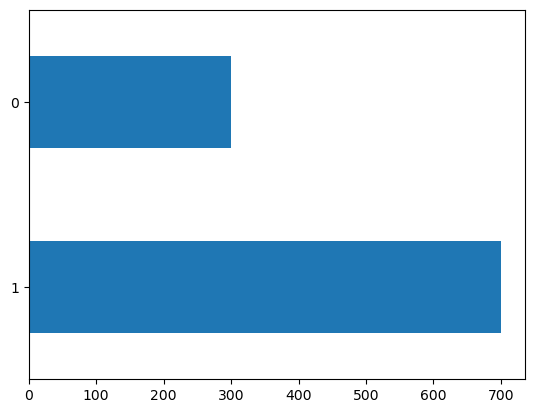

In [6]:
print(data['Creditability'].value_counts())
print(data['Creditability'].value_counts()/ data.shape[0])

data['Creditability'].value_counts().plot(kind = 'barh')
plt.show()

# 데이터 준비하기

#### 1) x, y로 나누기

In [7]:
target = 'Creditability'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

#### 2) 가변수화

In [8]:
dummy_vars = ['SexMarital', 'MostValuableAsset','ForeignWorker','Telephone']

x = pd.get_dummies(x, columns = dummy_vars, drop_first = True)
x.head()

,AccountBalance,Duration,Payment,Purpose,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4,ForeignWorker_2,Telephone_2
0,3,24,2,0,1249,2,2,28,2,1,3,1,0,0,1,0,0,0,0,0
1,2,9,2,0,276,3,4,22,1,1,2,1,0,0,1,0,0,0,0,0
2,1,18,3,2,1049,2,4,21,1,1,3,1,1,0,0,1,0,0,0,0
3,1,24,3,1,6419,5,4,44,3,2,4,2,1,0,0,0,0,1,0,1
4,3,12,2,2,1424,5,4,55,2,1,4,1,1,0,0,0,0,0,0,1


#### 3) train : validation 분할

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 2023)

# 모델링

In [12]:
# 모델을 만들경우
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

##### explainer 생성하기